# Histogramas para diagramas de constelación

## Tareas
- [X] Hacerlo 2D
- [ ] Con ambos utilizar un clasificador
- [ ] En caso tal, variar los bins

In [10]:
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker
import json
import os

from scipy.io import loadmat
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
from sklearn.metrics import (accuracy_score, f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from itertools import product
from time import time

In [6]:
# Función especial para leer todos los datos con la estructura estudiada
def read_data(folder_rx):
    data = {}

    # Leer la carpeta principal
    for folder in os.listdir(folder_rx):
        # Leer las subcarpetas
        if folder.endswith("spacing"):
            data[folder] = {}
            for file in os.listdir(f"{folder_rx}/{folder}"):
                if file.find("consY") != -1:
                    data_name = file.split("_")[2]
                    if data[folder].get(data_name) == None:
                        data[folder][data_name] = {}
                    mat_file_data = loadmat(f"{folder_rx}/{folder}/{file}")
                    data[folder][data_name] = mat_file_data
    return data

def plot_constellation_diagram(X, snr):
    plt.scatter(X.real, X.imag, alpha=0.5)
    plt.title(f"Constellation diagram for {snr[5:]}")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid(True)
    
    
def calculate_3d_histogram(X, bins, limits, spacing, snr):
    lower, higher = limits
    hist, xedges, yedges = np.histogram2d(X.real, X.imag, bins=bins, range=[[lower, higher], [lower, higher]])

    # Define the extent
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Create the meshgrid for the surface plot, excluding the last edge
    x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1])
    
    return hist, x_mesh, y_mesh
    
def plot_3d_histogram(X, bins, limits, spacing, snr, ax, histogram={}):
    hist, x_mesh, y_mesh = calculate_3d_histogram(X, bins, limits, spacing, snr)
    
    if histograms.get(f"{spacing}GHz_spacing") == None:
        histograms[f"{spacing}GHz_spacing"] = {}
    histograms[f"{spacing}GHz_spacing"][snr[5:]] = hist
    
    # Plot the 3D surface
    ax.plot_surface(x_mesh, y_mesh, hist.T, cmap="seismic", rstride=1, cstride=1, edgecolor="none")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    ax.set_title(f"3D Histogram")
    
    return histograms

def plot_histogram_and_gmm(X, bins, limits, ax, gaussians, index):
    hist_y, hist_x = np.histogram(X.real, bins=bins)
    # Remove last bin edge
    hist_x = hist_x[:-1]
        
    array = np.repeat(hist_x, hist_y).reshape(-1, 1)
    
    x = np.linspace(*limits, 1000)
    
    gm = GaussianMixture(n_components=4, means_init=np.array([-3, -1, 1, 3]).reshape(4, 1)).fit(array)
    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    if gaussians.get(f"{spacing}GHz_spacing") == None:
        gaussians[f"{spacing}GHz_spacing"] = {}
    if gaussians.get(f"{spacing}GHz_spacing").get(snr[5:]) == None:
        gaussians[f"{spacing}GHz_spacing"][snr[5:]] = [None, None, None]
    gaussians[f"{spacing}GHz_spacing"][snr[5:]][index] = gm
    
    ax.hist(X.real, bins=bins, density=True, alpha=0.5)
    ax.plot(x, pdf_individual, '--')
    plt.grid(True)
    
    return gaussians

def plot_gmm_2d(X_, bins, limits, ax, gaussians, snr, index):
    data = np.vstack((X_.real, X_.imag)).T
    means_init = np.array(list(product([-3, -1, 1, 3], repeat=2)))
    gm = GaussianMixture(n_components=16, means_init=means_init).fit(data)
    
    x = np.linspace(-5, 5)
    y = np.linspace(-5, 5)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    
    Z = -gm.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(
        X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 25), cmap="seismic"
    )
    
    plot_constellation_diagram(X_, snr)

    plt.title("Negative log-likelihood predicted")

    if gaussians.get(f"{spacing}GHz_spacing") == None:
        gaussians[f"{spacing}GHz_spacing"] = {}
    if gaussians.get(f"{spacing}GHz_spacing").get(snr[5:]) == None:
        gaussians[f"{spacing}GHz_spacing"][snr[5:]] = [None, None, None]
    gaussians[f"{spacing}GHz_spacing"][snr[5:]][index] = gm
    
    return gaussians

In [7]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)


def classifier_model(input_dim, layers_props_lst, classes_n, loss_fn):
    """ Compile a sequential model for classification purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")
    return model    


def classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks):
    """ Crossvalidation of a classification network. """
    # Store initial time
    t0 = time()

    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": []}
    scores["f1"] = {"train": [], "test": []}
    scores["cm"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        
        model = classifier_model(X_train.shape[1], layer_props, classes_n, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf)
        
        # Assign class based on higher probability in membership vector
        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            average="micro"
        )
        f1_score_test = f1_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            average="micro"
        )
         
        # Confusion Matrix
        cm_score_train = multilabel_confusion_matrix(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        cm_score_test = multilabel_confusion_matrix(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_classification_model(data, n_splits, max_neurons, activations, classes_n,
                               use_osnr=True, loss_fn="sparse_categorical_crossentropy"):
    """ Test a spectral overlapping classification model with given parameters. """
    # Set variable number
    var_n = 17 if use_osnr else 16
    
    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n]).T
    # Tags
    y = np.array(data[:, 19:20]).T
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]
    
    return classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks)

def plot_classes_scores(scores, scenario):
    score_names = ["acc"]
    data_type = ["train", "test"]
    markers = ["o", "D", "o", "D"]
    colors = ["dodgerblue", "dodgerblue", "red", "red"]
    
    # Plot loss
    plot_losses(scores, scenario, 
                lambda index: f"{'FCM' if index%2==0 else 'GKM'} {'B2B' if index<2 else 'optical fiber at ' + ('0' if index<4 else '9') + ' dBm'}",
                based_on_index=True)
    
    # Plot scores
    plot_scores(scores, ["B2B", "0 dBm", "9 dBm"], scenario, score_names,
                data_type, label=lambda index: f"{'FCM' if index%2==0 else 'GKM'}",
                xlabel="Scenario", markers=markers, colors=colors, multiple_points=True,
                based_on_index=True)
    plt.show()
    
def plot_cm(scores, interval_lst):
    CM = np.array(scores.get("cm").get("test"))
    for n, interval in enumerate(interval_lst):
        result = np.zeros(CM[0][0].shape)
        for cm in CM:
            result = np.add(result, cm[n])
        result /= np.sum(result)
        disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=["Positive", "Negative"])
        disp.plot(colorbar=False)
        lower_limit, upper_limit = interval 
        plt.title(f"Confusion matrix for class from {lower_limit} GHz up to {upper_limit} GHz")
        plt.show()

In [8]:
file_tx = "Demodulation/Data/2x16QAM_16GBd.mat"
folder_rx = "Demodulation/Data/"

# Transmitted data
X_tx_norm = loadmat(file_tx)
X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][0].flatten()
X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm

# Read received data
data = read_data(folder_rx)

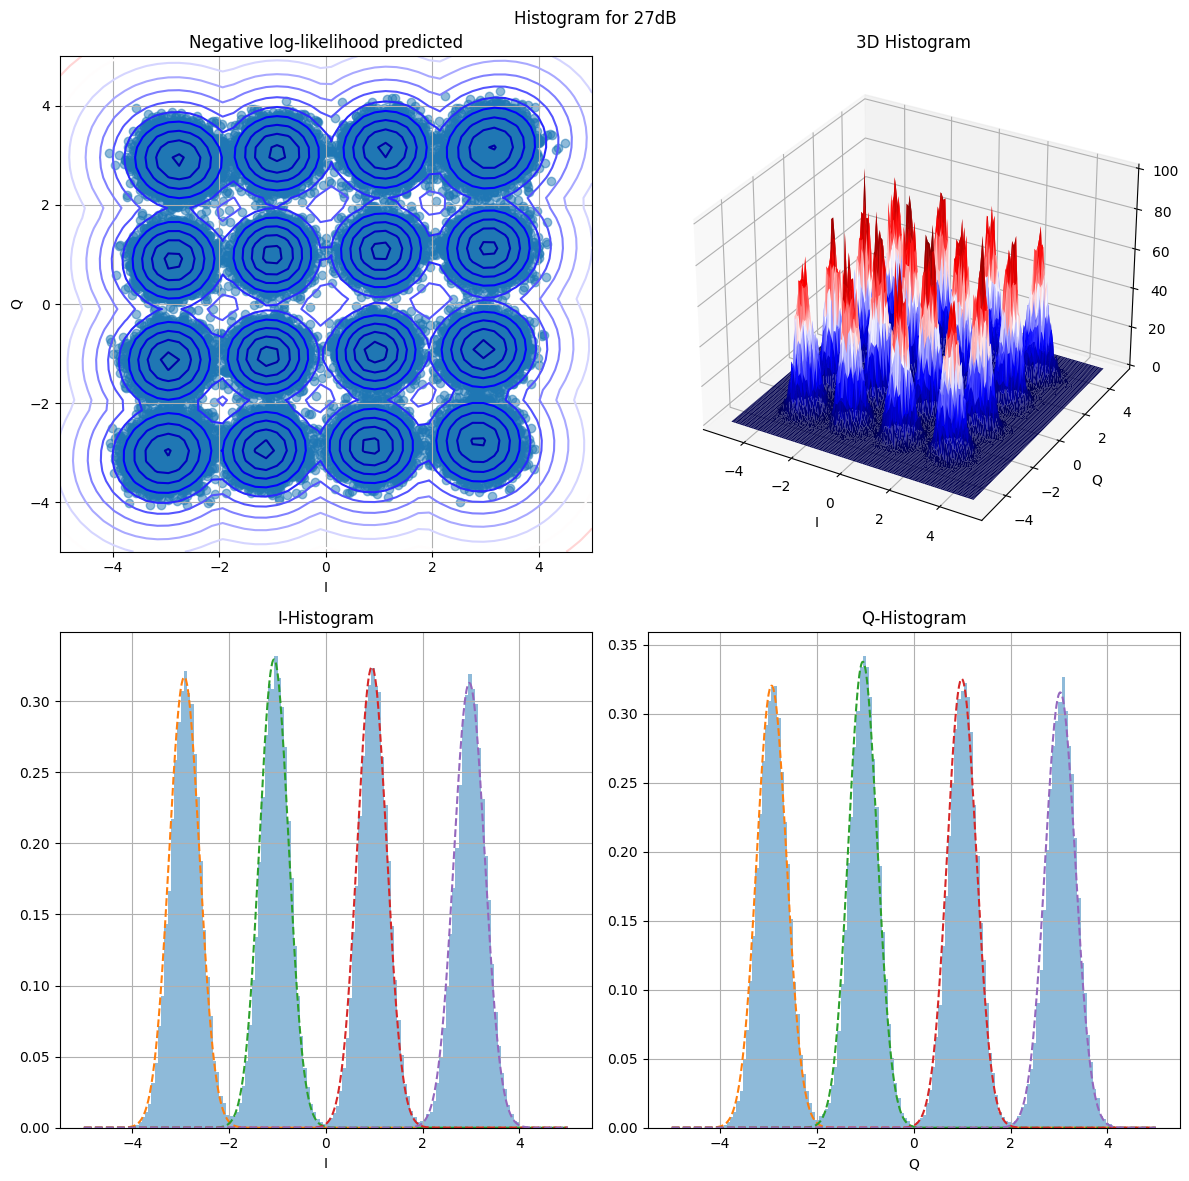

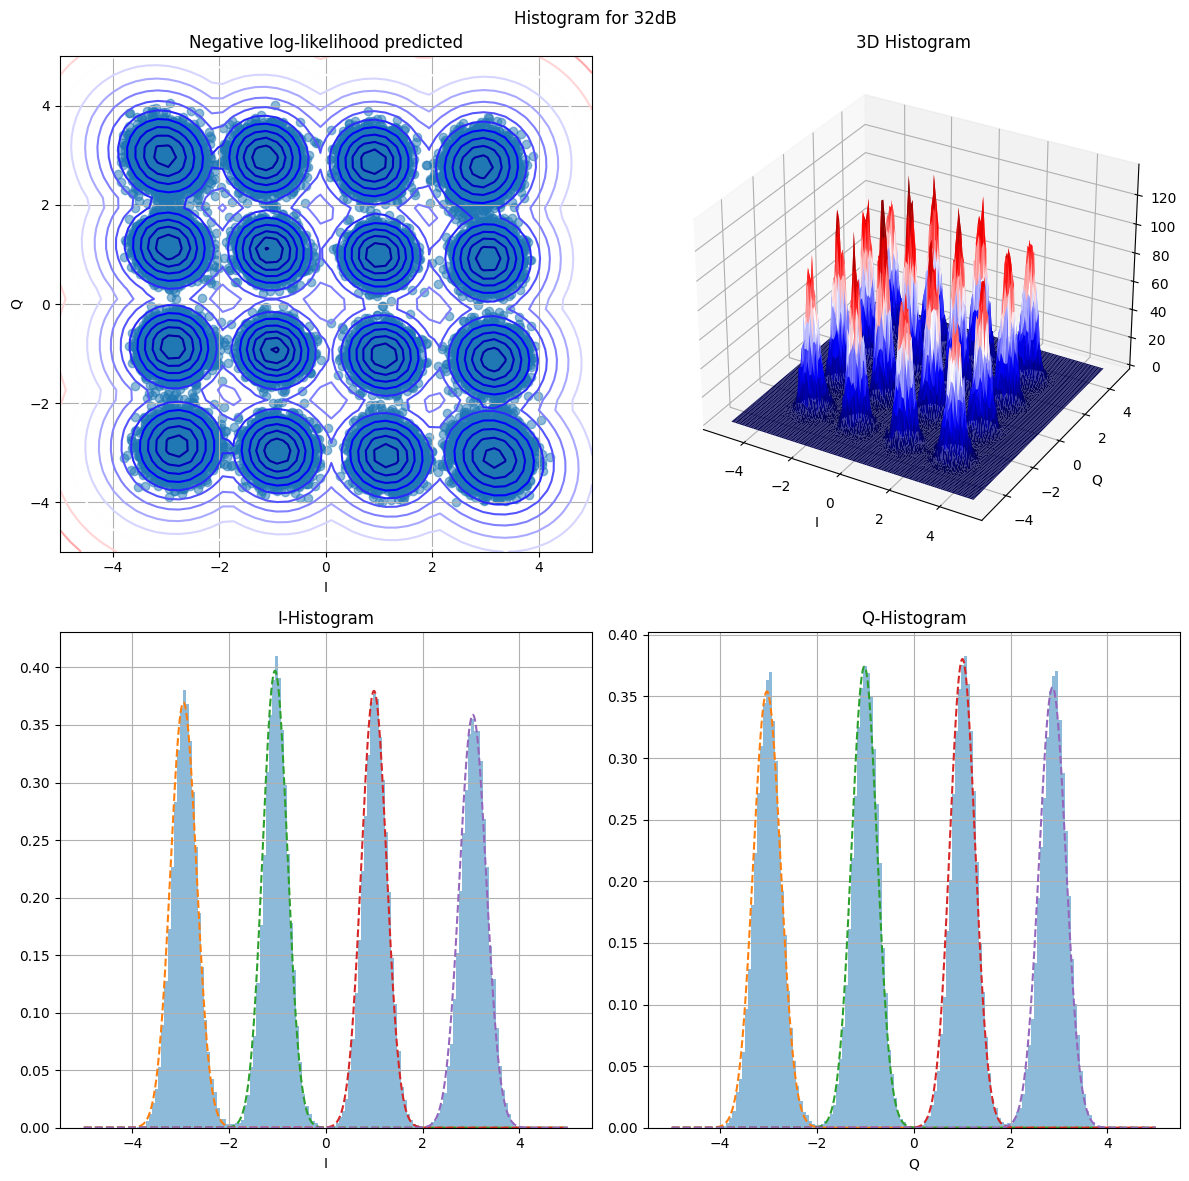

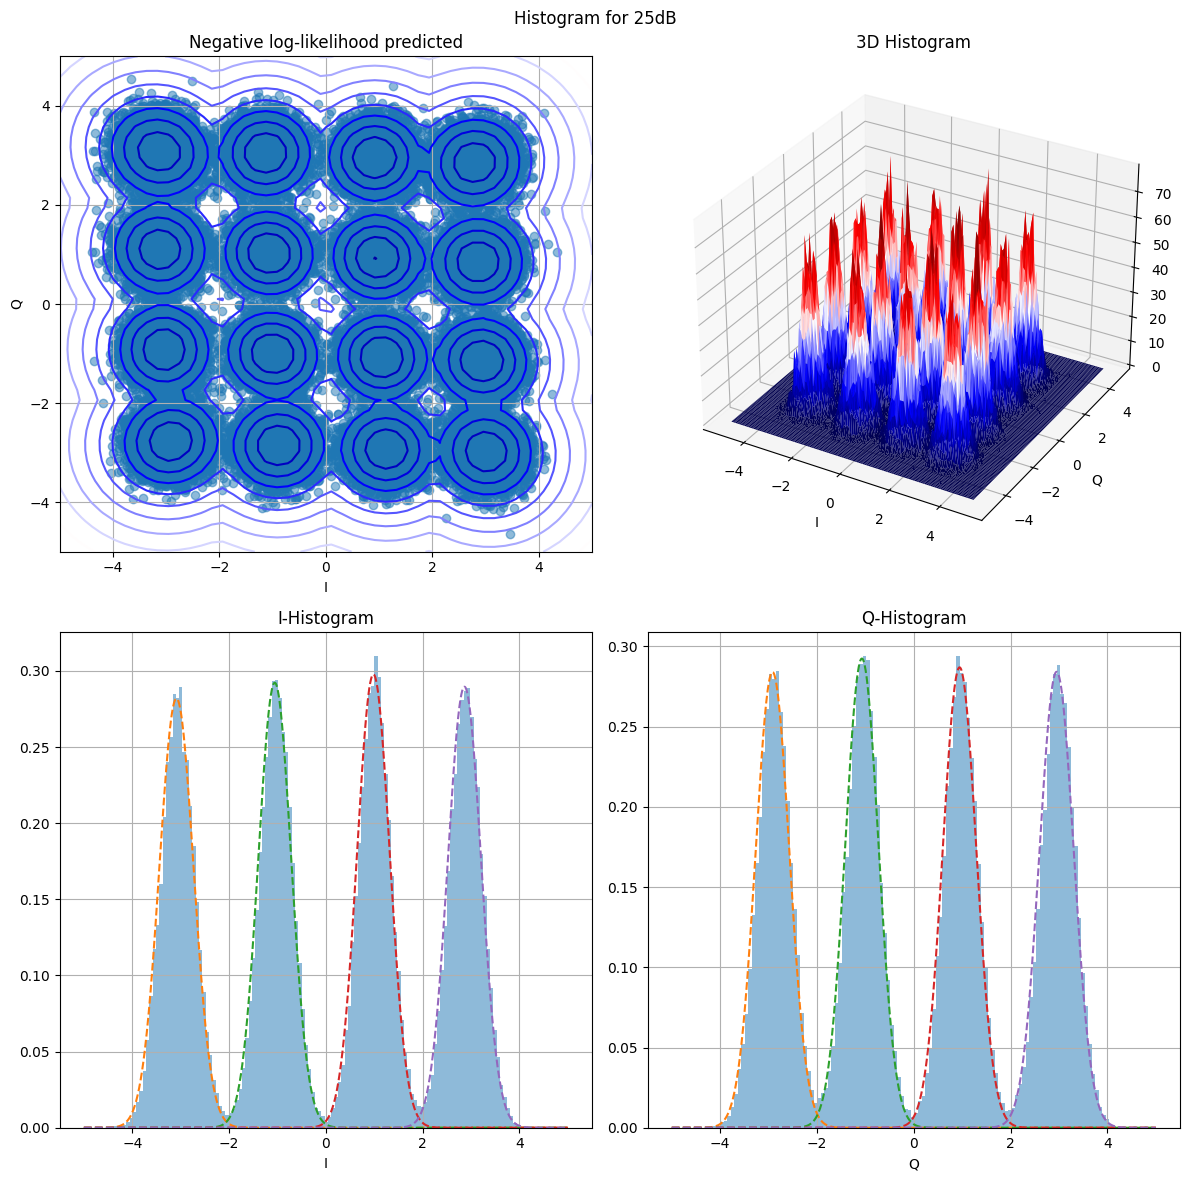

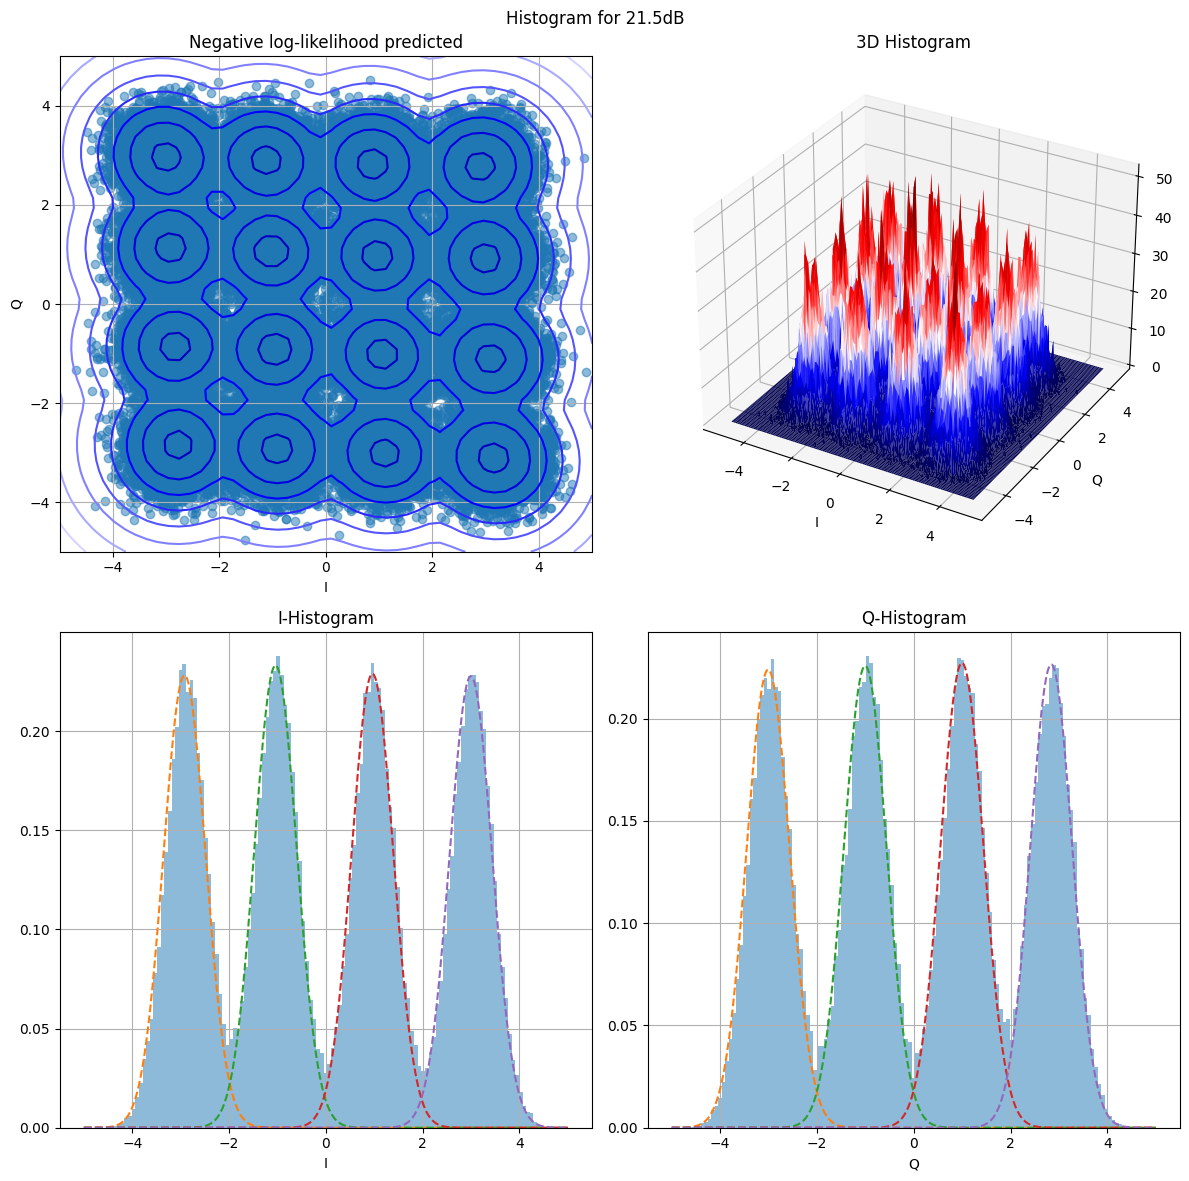

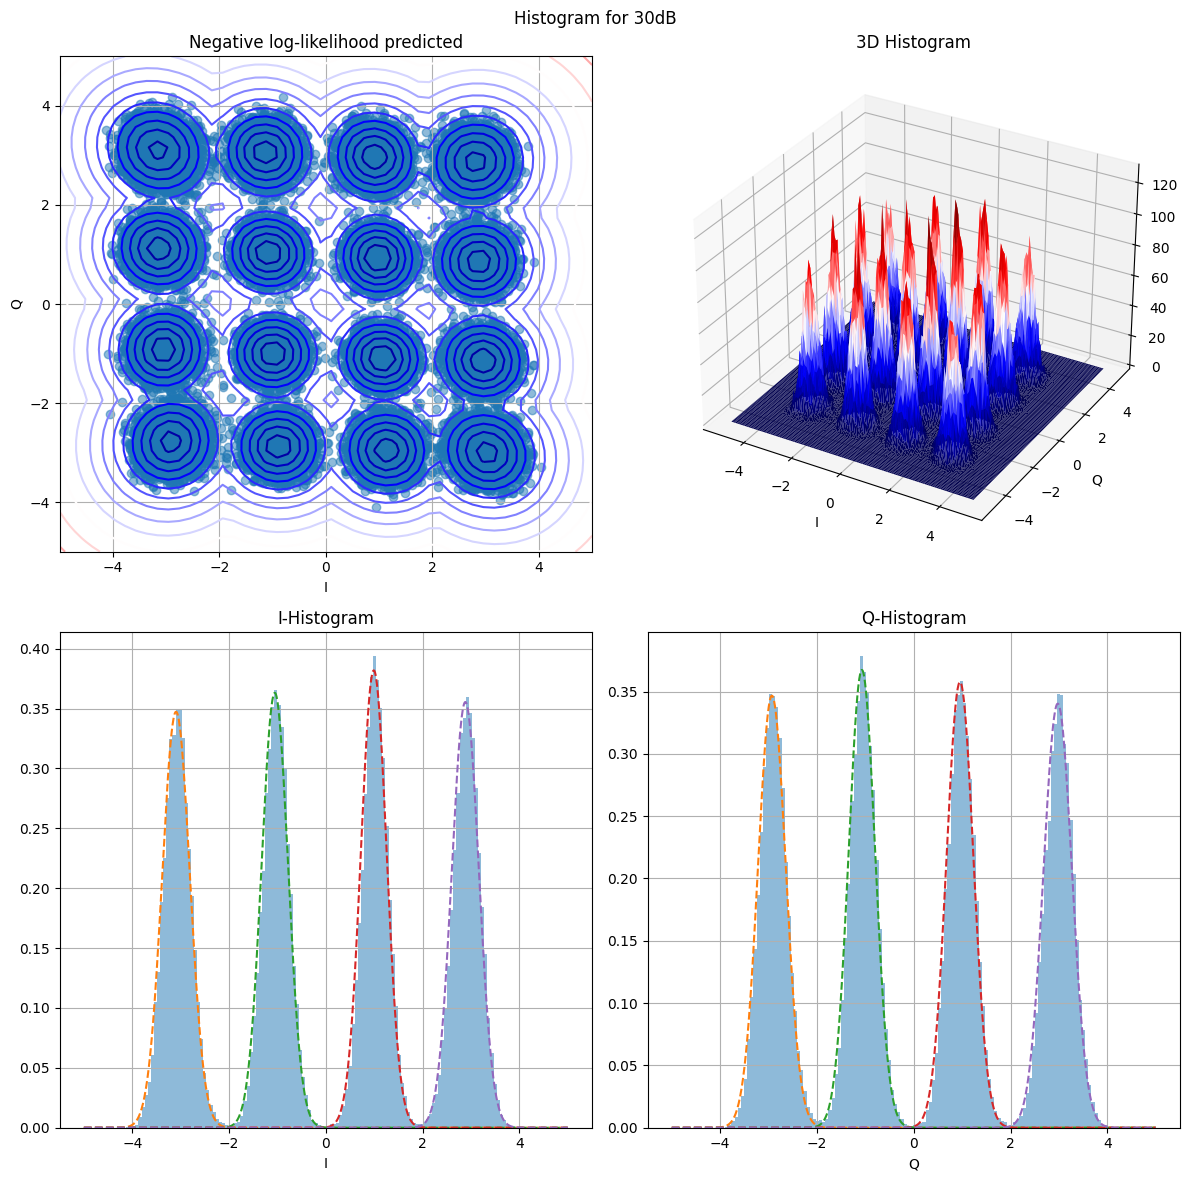

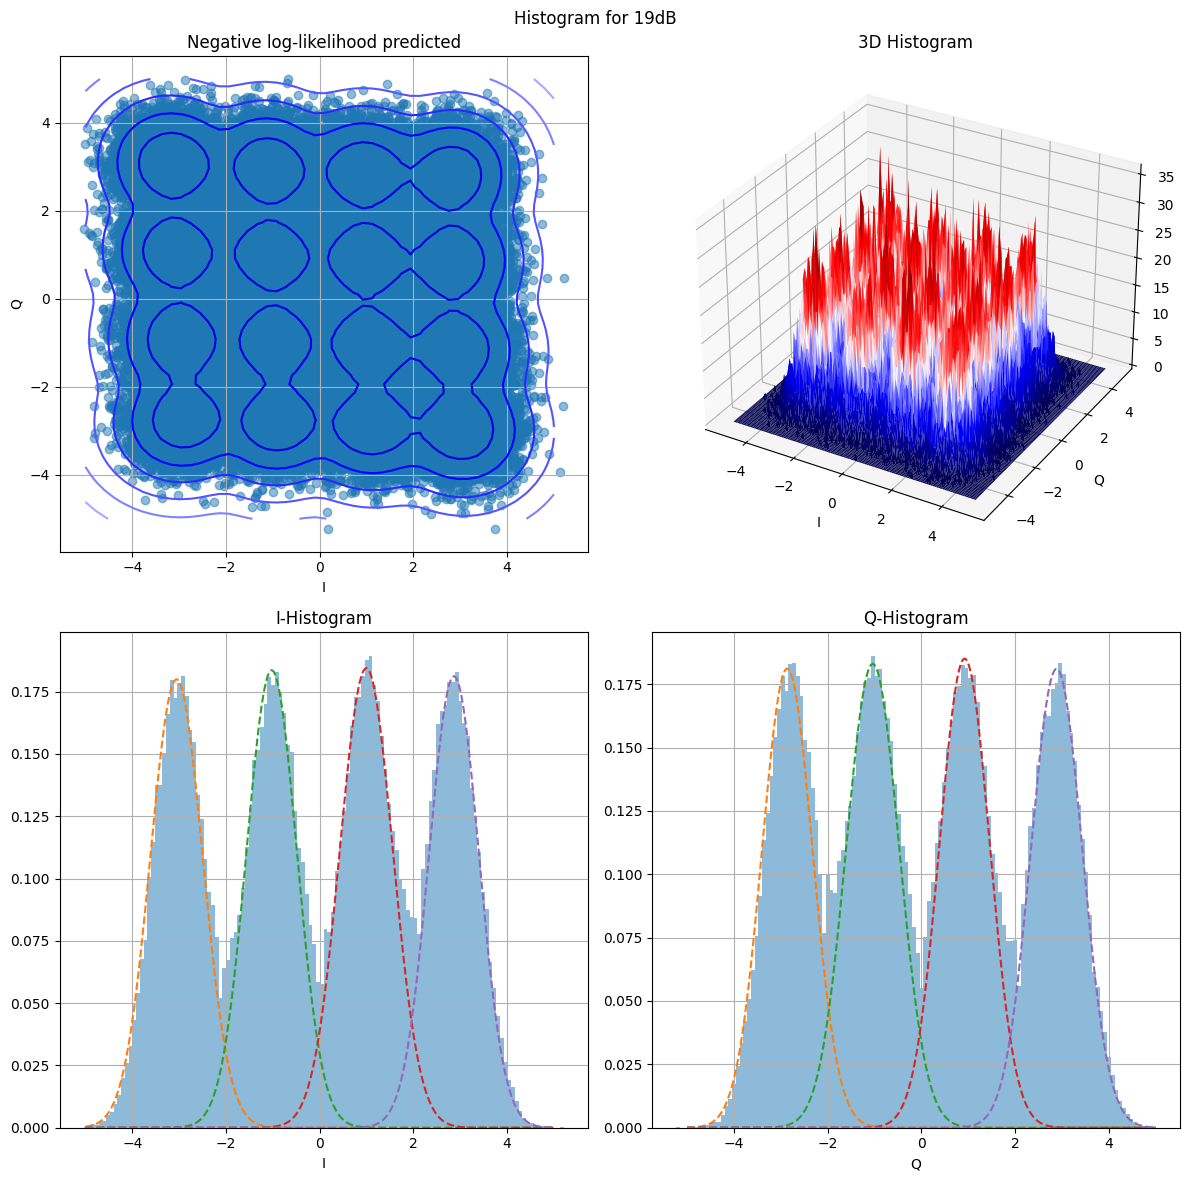

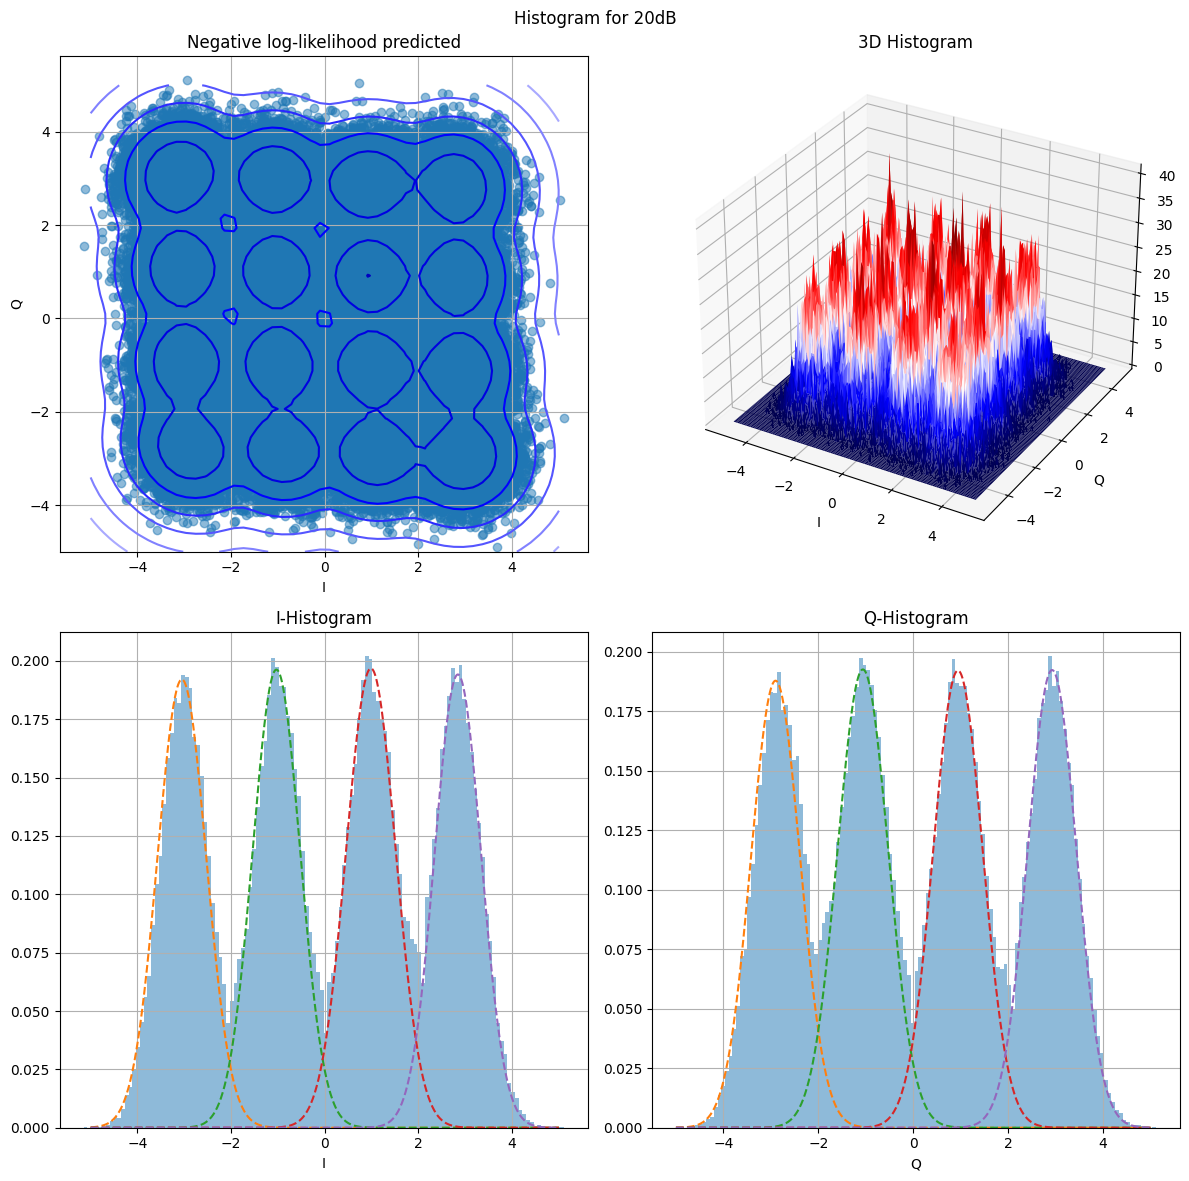

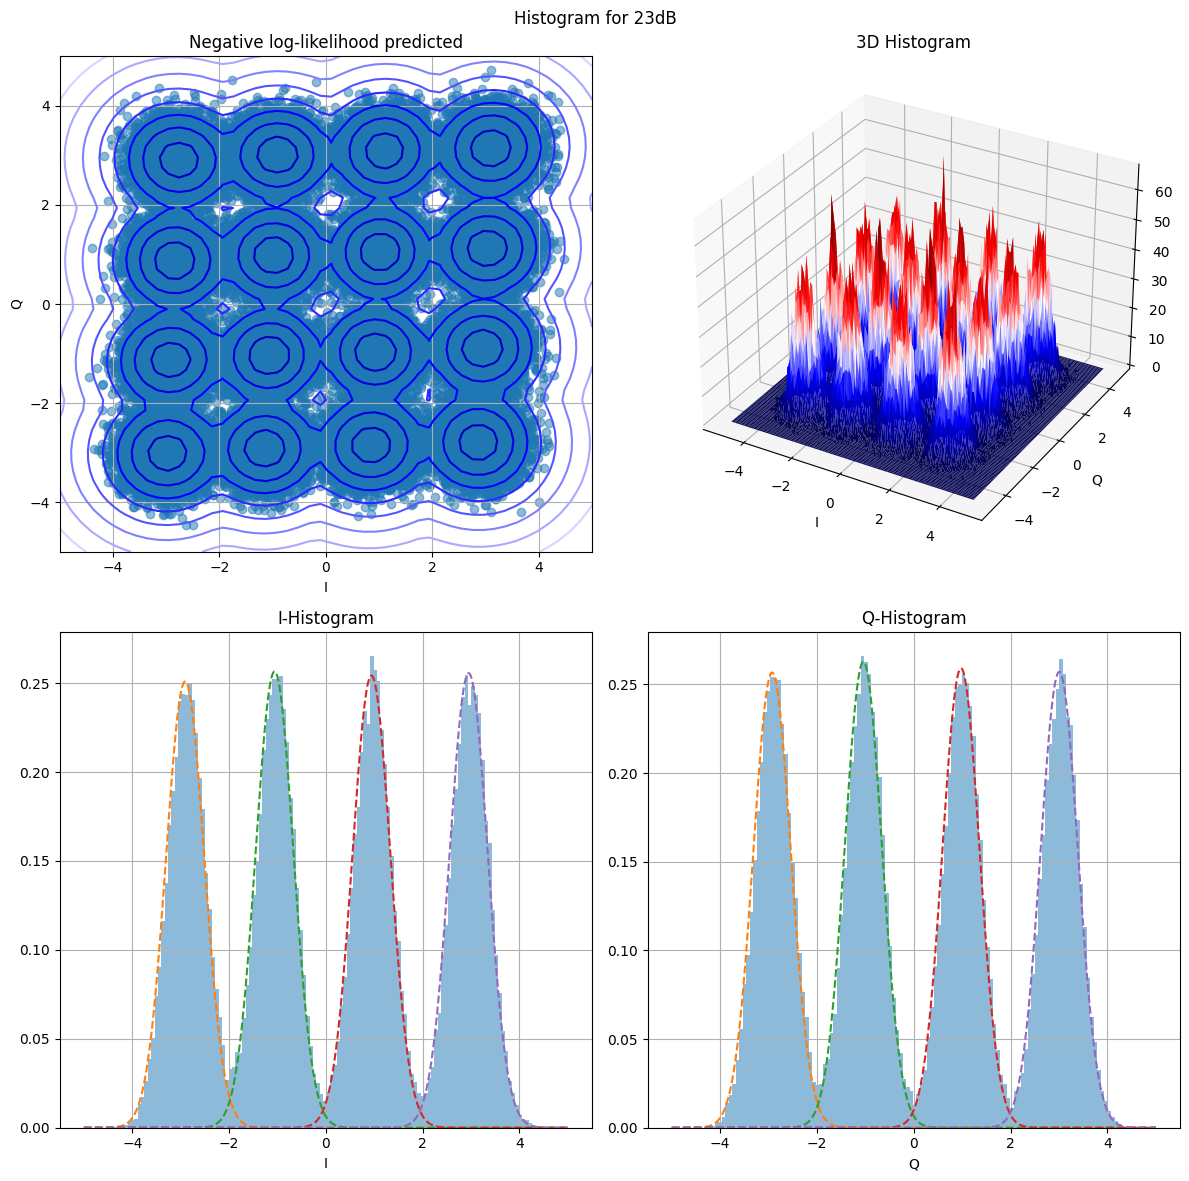

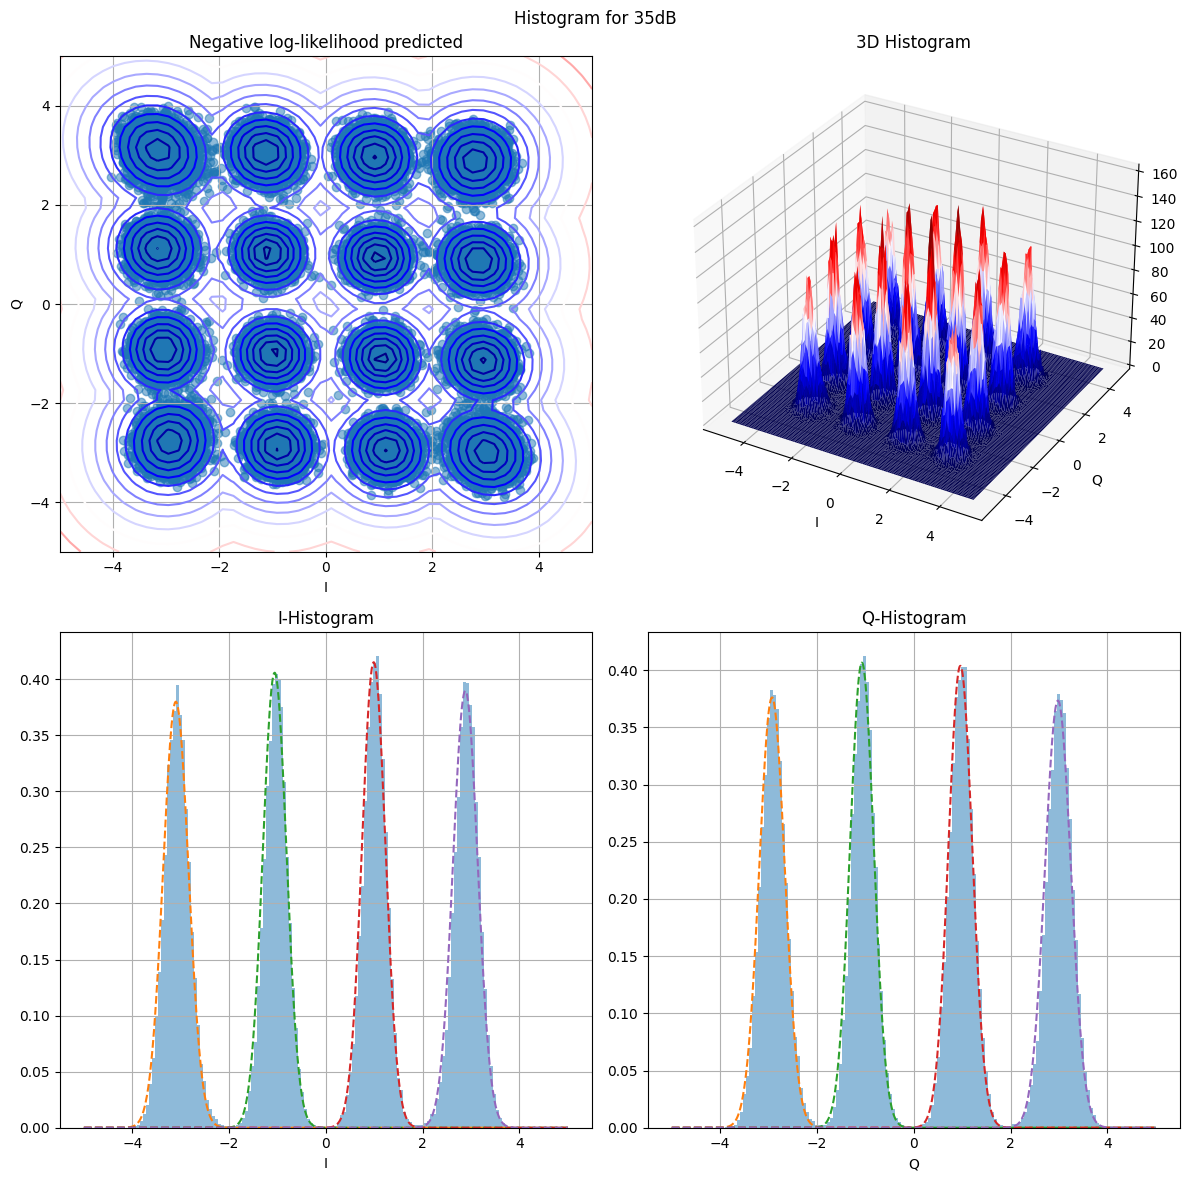

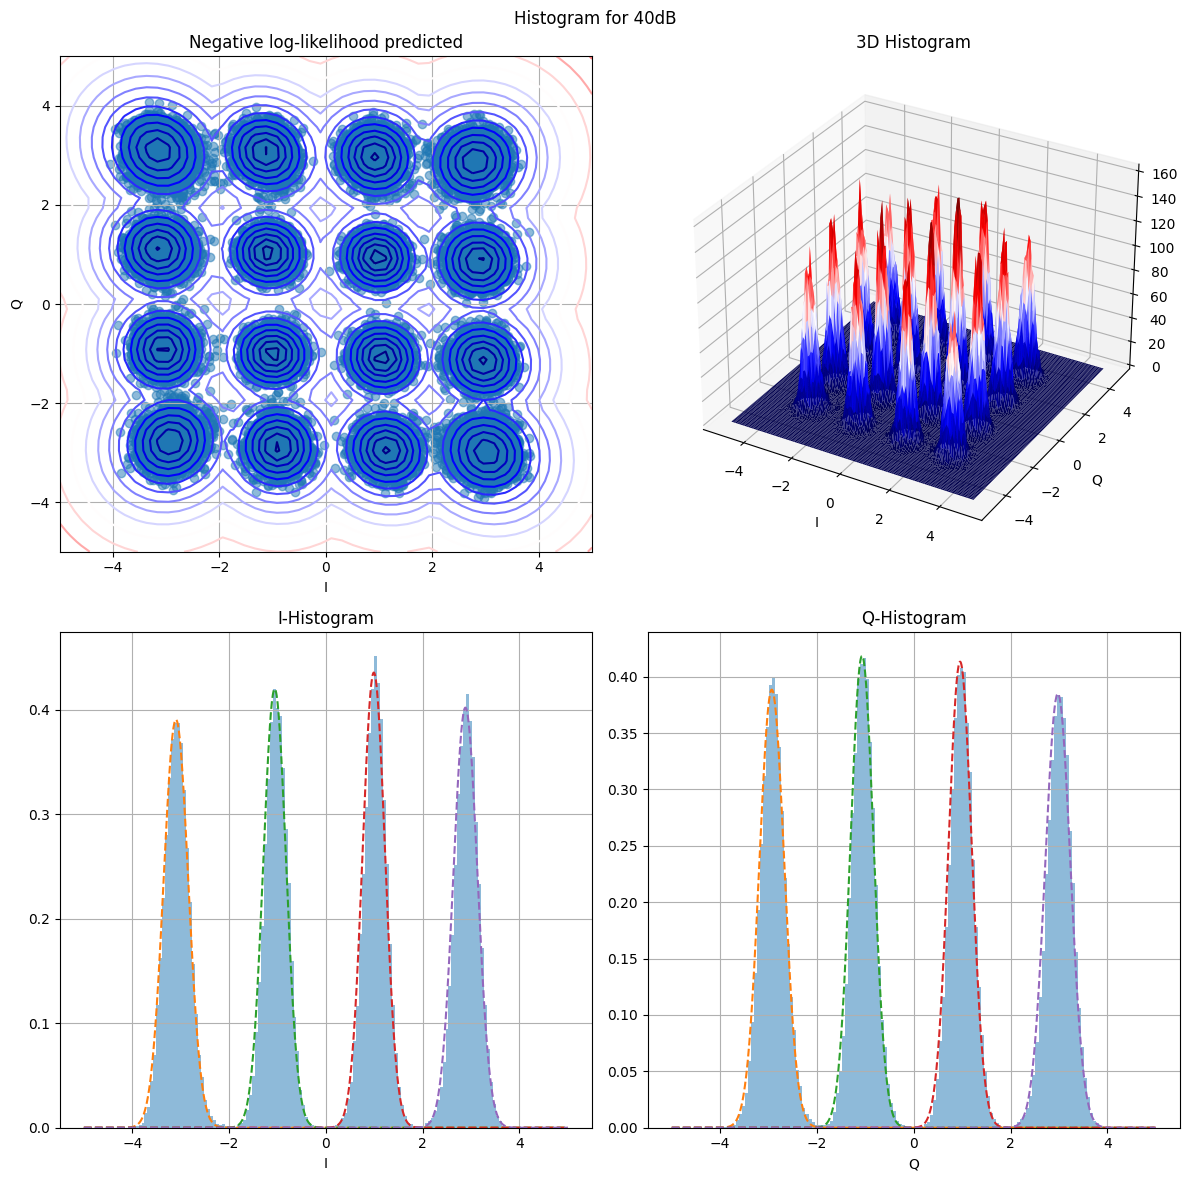

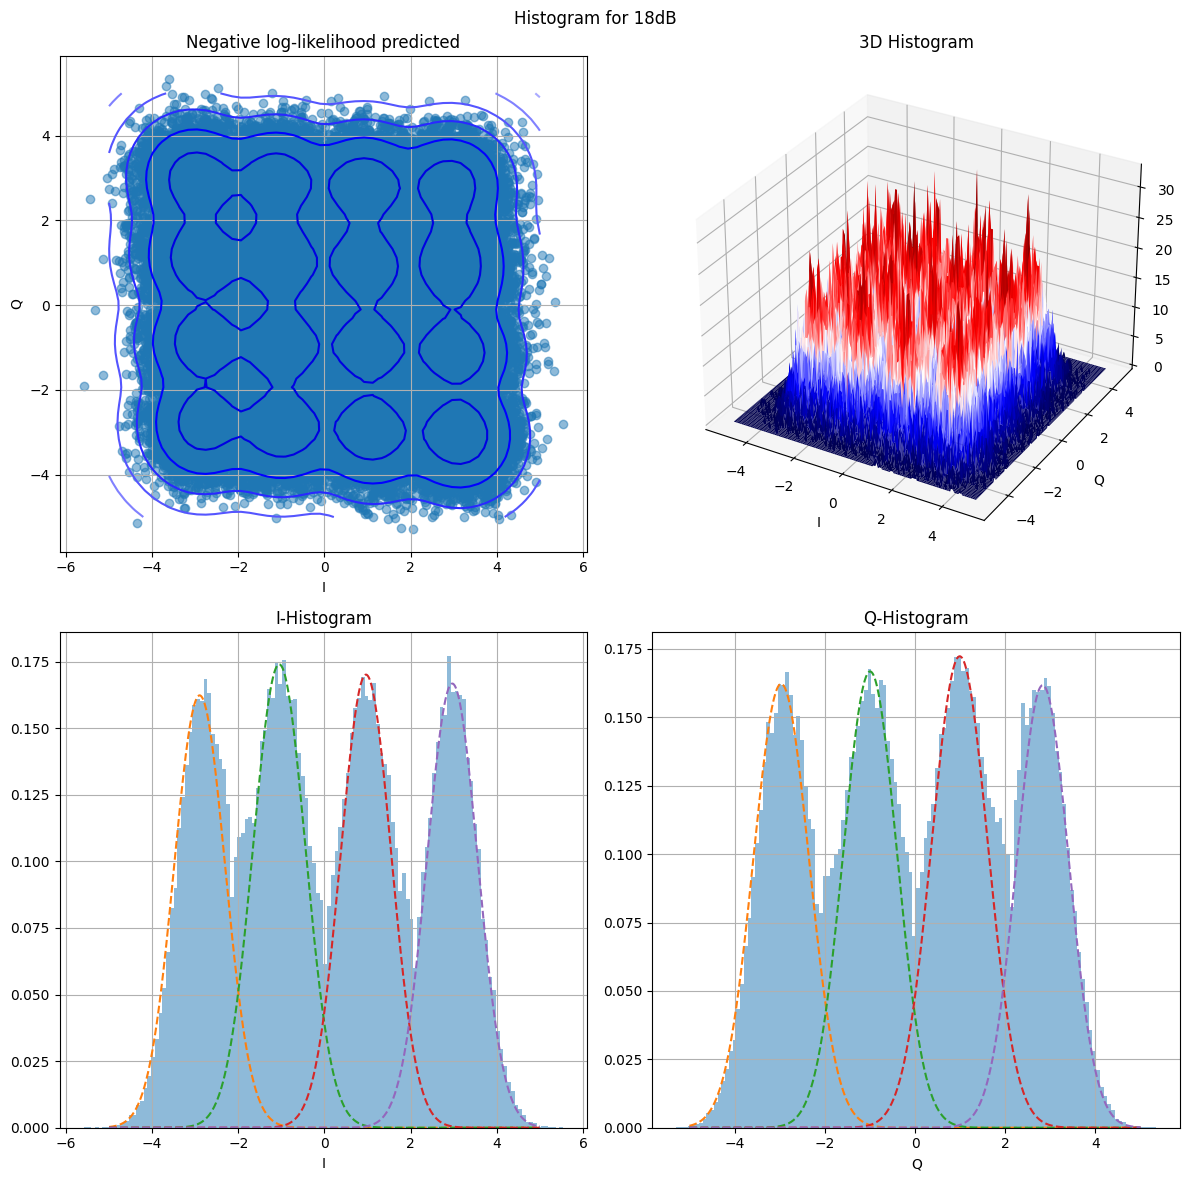

In [9]:
spacing = "17"
X_rx = data[f"{spacing}GHz_spacing"]

histograms = {}
gaussians = {}
bins = 128
limits = [-5, 5]

for i, snr in enumerate(X_rx):
    # Extract data 
    X_ch_norm = X_rx[snr].get("const_Y").flatten()
    X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm
    
    plt.figure(figsize=(12, 12), layout="tight")
    
    # Plot constellation diagram
    ax = plt.subplot(2, 2, 1)
    plot_gmm_2d(X_ch, bins, limits, ax, gaussians, snr, 0)
    
    # Plot 3D histogram
    ax = plt.subplot(2, 2, 2, projection="3d")
    histograms = plot_3d_histogram(X_ch, bins, limits, spacing, snr, ax, histograms)

    # Plot I and Q histograms separately
    # I
    ax = plt.subplot(2, 2, 3)
    plot_histogram_and_gmm(X_ch.real, bins, limits, ax, gaussians, 1)
    plt.title(f"I-Histogram")
    plt.xlabel("I")
    
    # Q
    ax = plt.subplot(2, 2, 4)
    plot_histogram_and_gmm(X_ch.imag, bins, limits, ax, gaussians, 2)
    plt.title(f"Q-Histogram")
    plt.xlabel("Q")
    
    plt.suptitle(f"Histogram for {snr[5:]}")
    
    plt.show()

In [31]:
g = gaussians.get("17GHz_spacing").get("21.5dB")
g[0].means_

array([[-2.77424929, -2.83869994],
       [-2.83158501, -0.84689022],
       [-2.91121758,  1.14304392],
       [-3.0023826 ,  2.9756505 ],
       [-0.91363131, -2.91677161],
       [-0.95474732, -0.91628183],
       [-1.02462039,  1.06729594],
       [-1.12190584,  2.91074678],
       [ 1.10153729, -3.01077499],
       [ 1.05217741, -1.02399889],
       [ 0.96818383,  0.98469005],
       [ 0.86827763,  2.85138095],
       [ 3.14961747, -3.10503413],
       [ 3.09052479, -1.1029996 ],
       [ 2.99533591,  0.91634577],
       [ 2.89291168,  2.77865849]])

In [25]:
print(g)

None


In [ ]:
args = {"data": df_2classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_B2B = calc_once("scores_2classes_FCM_B2B", test_classification_model, args)